# Delivery Apps Reviews: Service and App Classificaition

This notebook explores classification using BERT model BETO (Spanish cased pre-trained BERT Model) to decide if the app review is referring to the app itself or to the service provided when handling the delivery. 

Several data-augmentation techniques are explored including:

- Word Embedding Augmenter: Some words are replaced at random in the review using an embedding layer that can be found [here](https://https://github.com/dccuchile/spanish-word-embeddings#fasttext-embeddings-from-sbwc). This output some new reviews that can be used to train the model

- Concatenate Comments: Some reviews are concatenated at random. The outcome gives a new review that targets both App and Service.

Sentiment analysis and data extraction is done in this notebook: [Sentiment Analysis Notebook using BERT](https://colab.research.google.com/drive/1lRelEPqIzxSbQq09KGXHVjSo37WGXwwZ)

# Imports, Global Variables and Downloads

In [1]:
!pip install transformers==3.3.1
!pip install nlpaug

     |████████████████████████████████| 1.1MB 12.5MB/s 
     |████████████████████████████████| 1.1MB 56.6MB/s 
     |████████████████████████████████| 890kB 55.8MB/s 
     |████████████████████████████████| 3.0MB 58.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=6eacf5c453699847b94a74235c4f4628be76ebf7c1347a474e88d463a58a793c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 389kB 17.5MB/s 


In [32]:
import transformers
import torch

from tqdm import tqdm

from google.colab import files

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nlpaug.augmenter.word as naw


from collections import defaultdict

from torch import nn

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from torch.utils import data

BERT_HUGGINGFACE_PRE_TRAINED_MODEL_NAME = 'dccuchile/bert-base-spanish-wwm-cased'

MAX_LEN = 70
BATCH_SIZE = 64 # 8, 16, 32, 64, 128
EPOCHS = 16
RANDOM_SEED = 42
TARGET_CLASSES = ["App", "Service"] # Model can be trained for detecting comments referred to "App" or "Service"
DOWNLOAD_MODEL = True

#### Verision and packages

In [3]:
print(f'Transformers: {transformers.__version__}')
print(f'Torch: {torch.__version__}')

Transformers: 3.3.1
Torch: 1.7.0+cu101


In [4]:
!gdown --id 1I1uhw2mG56H0_hy8aZ1S-xcLyprXuuwY --output review_dataset.csv
!gdown --id 1ytY_Pr1XUy9v5abbOxBIHdcZ0GMJl1M2 --output fasttext-sbwc.vec

Downloading...
From: https://drive.google.com/uc?id=1I1uhw2mG56H0_hy8aZ1S-xcLyprXuuwY
To: /content/review_dataset.csv
100% 247k/247k [00:00<00:00, 7.82MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ytY_Pr1XUy9v5abbOxBIHdcZ0GMJl1M2
To: /content/fasttext-sbwc.vec
2.24GB [00:25, 89.0MB/s]


In [5]:
!nvidia-smi

Tue Jan  5 01:31:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Choose dataset and classification target

In [7]:
def get_dataset_dataset(file, columns, index, convert2int64, naval=-1, preview=False):
    """Carga el csv de file
    Completa las columnas con los valores requeridos
    Pasa todos los valores numericos a int64.
    Vuela el doble Index
    Vuela todos los NaN: Poner el numero 'naval' para los valores null """
    df = pd.read_csv(file, names=columns)
    df.set_index(index, inplace=True)

    for col in convert2int64:
        df[col] = df[col].fillna(naval)
        df[col] = df[col].astype(np.float64)
    
    if preview:
        print(df.head())
        print('\n', "-------------------------", '\n')
        print(df.info())
    
    return df

df = get_dataset_dataset(
    "review_dataset.csv",
    ["Index", "Content", "Sentiment", "App", "Service", "Support"],
    'Index',
    convert2int64=['Sentiment', 'App', "Service", "Support"],
    preview=True
)

                                  Content  Sentiment  App  Service  Support
Index                                                                      
2094                Agilidad y protocolos        2.0 -1.0      2.0     -1.0
474                              Exelente        2.0  2.0     -1.0     -1.0
874       Muy buena recepcion de producto        2.0 -1.0      2.0     -1.0
189    Se queda en negro al querer entrar        0.0  0.0     -1.0     -1.0
1976                          son lindos!        2.0 -1.0     -1.0     -1.0

 ------------------------- 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2150 entries, 2094 to 1352
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Content    2150 non-null   object 
 1   Sentiment  2150 non-null   float64
 2   App        2150 non-null   float64
 3   Service    2150 non-null   float64
 4   Support    2150 non-null   float64
dtypes: float64(4), object(1)
memory usage: 100.8

In [8]:
def get_dataset_for_classification(df, target_clases, binarize=True, binval=-1, preview=False):
    """Returns the dataframe with its content and a specific class for classification
    If binarize is set to True, it returns the class binabinarized_service_df.head()
    binarized_service_df.info() rized, mapping binval to 0 and other to 1
    """
    cols = ['Content']
    for clase in target_clases:
        cols.append(clase)
    
    new_df = df[cols].copy()

    if binarize:
        for clase in target_clases:
            new_df[clase] = new_df[clase].apply(lambda x: 0 if x == binval else 1)

    if preview:
        print(new_df.head())
        print('\n', "-------------------------", '\n')
        print(new_df.info())

    return new_df

binarized_class_df = get_dataset_for_classification(df, TARGET_CLASSES, preview=True)

                                  Content  App  Service
Index                                                  
2094                Agilidad y protocolos    0        1
474                              Exelente    1        0
874       Muy buena recepcion de producto    0        1
189    Se queda en negro al querer entrar    1        0
1976                          son lindos!    0        0

 ------------------------- 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2150 entries, 2094 to 1352
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Content  2150 non-null   object
 1   App      2150 non-null   int64 
 2   Service  2150 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 67.2+ KB
None


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f742b762080>,
      dtype=object)

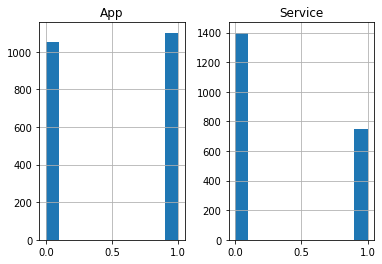

In [9]:
binarized_class_df.hist()

# Data Augmentation: Concatenate Comments

Este proceso se realiza antes de categorizar para poder hacer uso del hecho de que los datos vienen con binary encoding

La idea que puede servir para augmentar es concatenar comentarios de clases distintas para que el modelo entienda que cuando un comentario habla de muchas clases, tambien pertenece a la que uno esta analizando

In [10]:
SKIP_STEP_DACC = False

In [11]:
def random_comment_concat(df, nanval=0, concat_prob=0.3, test_fun=False):
    df = df.copy()
    prev_comment = None
    for _, row in tqdm(df.iterrows()):
        if (np.random.random() < concat_prob and prev_comment is not None):
            
            if test_fun:
                print()
                print(f'Previous comment: {prev_comment}')
                print(f'Actual comment: {row["Content"]}')
            
            new_comment = row['Content'] + ' ' + prev_comment
            
            if test_fun:
                print(f'New comment: {new_comment}')
                print()
                print(f'Previous target App: {prev_target_app}')
                print(f'Actual target App: {row["App"]}')
                print(f'New target App: {row["App"] or prev_target_app}')
                print()
                print(f'Previous target Service: {prev_target_service}')
                print(f'Actual target Service: {row["Service"]}')
                print(f'New target Service: {row["Service"] or prev_target_service}')

                break
            
            df = df.append({
                'Content': new_comment,
                'App': row['App'] or prev_target_app,
                'Service': row['Service'] or prev_target_service
            }, ignore_index=True)

        prev_comment = row['Content']
        prev_target_app = row['App']
        prev_target_service = row['Service']

    return shuffle(df)

In [12]:
if not SKIP_STEP_DACC:
    binarized_class_df = random_comment_concat(binarized_class_df, test_fun=False)

2150it [00:01, 1205.22it/s]


# Data analysis

## Labeling

In [13]:
def to_cat(a):
    if a['App'] == 1 and a['Service'] == 1:
        return 3
    elif a['App'] == 1 and a['Service'] == 0:
        return 2
    elif a['App'] == 0 and a['Service'] == 1:
        return 1
    else:
        return 0

binarized_class_df['Target'] = binarized_class_df[['App', 'Service']].apply(to_cat, axis=1)

In [14]:
binarized_class_df['Target'].value_counts(normalize=False)

2    1201
1     737
0     469
3     373
Name: Target, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


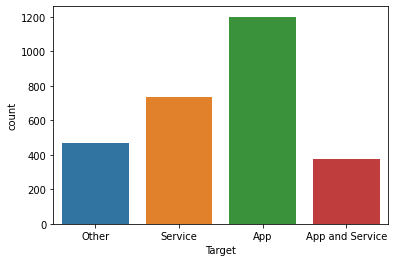

In [15]:
ax = sns.countplot(binarized_class_df['Target'])
ax.set_xticklabels(['Other', 'Service', 'App', 'App and Service']);

## Train Val Test Split

In [16]:
df_train, df_test = train_test_split(binarized_class_df, test_size=0.2, random_state=RANDOM_SEED, stratify=binarized_class_df['Target'])
df_val, df_test = train_test_split(binarized_class_df, test_size=0.5, random_state=RANDOM_SEED, stratify=binarized_class_df['Target'])

In [17]:
print("Train Target Proportions:")
print(df_train['Target'].value_counts(normalize=True))
print("Validation Target Proportions:")
print(df_val['Target'].value_counts(normalize=True))
print("Test Target Proportions:")
print(df_test['Target'].value_counts(normalize=True))

Train Target Proportions:
2    0.432104
1    0.265288
0    0.168615
3    0.133993
Name: Target, dtype: float64
Validation Target Proportions:
2    0.431655
1    0.265468
0    0.168345
3    0.134532
Name: Target, dtype: float64
Test Target Proportions:
2    0.432374
1    0.264748
0    0.169065
3    0.133813
Name: Target, dtype: float64


# Text Preprocessing

In [18]:
tokenizer = transformers.BertTokenizer.from_pretrained(BERT_HUGGINGFACE_PRE_TRAINED_MODEL_NAME)

# Creating Torch Dataset

In [19]:
class GPReviewDataset(data.Dataset):
    """https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset"""

    def __init__(self, review, target, tokenizer, max_len):
        self.review = review
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.review)

    def __getitem__(self, item):
        review = str(self.review[item])

        encoding = tokenizer.encode_plus(
            review,
            max_length=self.max_len,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(self.target[item], dtype=torch.long),

        }

# Data Augmentation: Word Embedding Agumenter

Esto puede llevar como 6 minutos

In [20]:
SKIP_STEP_DAWEA = False

In [21]:
def augment_df_with_nlpaug(df, content, target, aug_p=0.25, df_p=0.2, test_fun=False):
    """Augments the content of the dataset with similar words but retaining the target.
    
    Args:
    :df: Dataframe to agument
    :content: column to agument
    :target: column target
    :bert_model: path to the pre trained bert model to use, default is set to hugging face transformer library
    :aug_p: probability of changing a word
    :df_p: probability to augment the row. 1 Augments all the dataset duplicating it.
    
    Returns:
    shuffled dataset with the new rows

    https://github.com/makcedward/nlpaug/blob/master/example/textual_language_augmenter.ipynb
    """
    df = df.copy()

    aug = naw.WordEmbsAug(
        model_type='fasttext',
        model_path="fasttext-sbwc.vec",
        aug_min=2,
        aug_p=aug_p,
        aug_max=3
        )

    for _, row in tqdm(df.iterrows()):
        if test_fun:
            print({
                content: aug.augment(row[content]),
                target: row[target]
            })
            break
        if np.random.random() < df_p: 
            df = df.append({
                content: aug.augment(row[content]),
                target: row[target]
            }, ignore_index=True)

    return shuffle(df)

In [22]:
if not SKIP_STEP_DAWEA:
    df_train = augment_df_with_nlpaug(
        df_train,
        content='Content',
        target='Target',
        test_fun=False # True, devuelve el primer comentario del df augmentado para poder observar
        )

2224it [03:31, 10.49it/s]


# Data Shape

In [23]:
df_train.shape, df_val.shape, df_test.shape

((2689, 4), (1390, 4), (1390, 4))

# Create Dataloader

In [24]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        review=df['Content'].to_numpy(),
        target=df['Target'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return data.DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

print(len(val_data_loader) * BATCH_SIZE)
print(len(df_val['Target']))

data_batch = next(iter(train_data_loader)) # Returns a batch
print("BATCH CHECK")
print("-" * 40)
print("Batch keys:")
print(data_batch.keys())
print("-" * 40)
print("Batch input")
print(data_batch['input_ids'])
print("-" * 40)
print("Batch Targets")
print(data_batch['targets'])

1408
1390
BATCH CHECK
----------------------------------------
Batch keys:
dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
----------------------------------------
Batch input
tensor([[    4,  6850,  1127,  ...,     1,     1,     1],
        [    4,  1177, 14259,  ...,     1,     1,     1],
        [    4, 21716, 30933,  ...,     1,     1,     1],
        ...,
        [    4,  8395,  1674,  ...,     1,     1,     1],
        [    4,  2717, 15217,  ...,     1,     1,     1],
        [    4, 10182,  2988,  ...,  7345,  1008,     5]])
----------------------------------------
Batch Targets
tensor([0, 2, 1, 0, 3, 2, 2, 0, 1, 2, 1, 2, 2, 3, 2, 2, 0, 0, 2, 2, 0, 2, 0, 1,
        2, 1, 2, 1, 0, 2, 0, 2, 2, 2, 0, 2, 2, 1, 1, 0, 3, 1, 3, 2, 2, 0, 1, 1,
        2, 2, 2, 2, 2, 1, 0, 2, 0, 3, 0, 3, 2, 2, 1, 1])


# Building Classifier

In [25]:
class ReviewClassifier(nn.Module):

    def __init__(self, n_classes):
        super(ReviewClassifier, self).__init__()
        self.bert = transformers.BertModel.from_pretrained(BERT_HUGGINGFACE_PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes) # = Dense en keras

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)

        return self.out(output)

In [26]:
N_CLASSES = 4
model = ReviewClassifier(N_CLASSES)
model = model.to(device)

# Training

In [27]:
optimizer = transformers.AdamW(model.parameters(), lr=2e-5, correct_bias=False) # based in BERT paper

total_steps = len(train_data_loader) * EPOCHS # BATCH * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)
loss_fn.requres_grad = True

In [28]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader):
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # If gradients are to large, the training is unstable, so gradient clipping fixes this
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [29]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in tqdm(data_loader):
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)

      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [30]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print()
    print()
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    print()

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_data_loader)*BATCH_SIZE
    )

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(val_data_loader) * BATCH_SIZE
    )

    print()
    print(f'Train   loss {train_loss} accuracy {train_acc}')
    print(f'Val     loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'model.bin')
        best_accuracy = val_acc

  0%|          | 0/43 [00:00<?, ?it/s]



Epoch 1/16
----------



100%|██████████| 22/22 [00:05<00:00,  3.85it/s]



Train   loss 1.1429270755412966 accuracy 0.5221656976744186
Val     loss 0.7585899775678461 accuracy 0.7137784090909091



  0%|          | 0/43 [00:00<?, ?it/s]



Epoch 2/16
----------



100%|██████████| 22/22 [00:05<00:00,  3.80it/s]



Train   loss 0.69899934322335 accuracy 0.7242005813953488
Val     loss 0.4421556727452712 accuracy 0.8274147727272727



  0%|          | 0/43 [00:00<?, ?it/s]



Epoch 3/16
----------



100%|██████████| 22/22 [00:06<00:00,  3.54it/s]



Train   loss 0.43254494831659074 accuracy 0.8284883720930233
Val     loss 0.26408686725930736 accuracy 0.9055397727272727



  0%|          | 0/43 [00:00<?, ?it/s]



Epoch 4/16
----------



100%|██████████| 22/22 [00:06<00:00,  3.66it/s]



Train   loss 0.2844464259092198 accuracy 0.889171511627907
Val     loss 0.22064740447835487 accuracy 0.9169034090909092



  0%|          | 0/43 [00:00<?, ?it/s]



Epoch 5/16
----------



100%|██████████| 22/22 [00:06<00:00,  3.60it/s]



Train   loss 0.20654680912361242 accuracy 0.9058866279069767
Val     loss 0.14694177376275713 accuracy 0.9389204545454546



  0%|          | 0/43 [00:00<?, ?it/s]



Epoch 6/16
----------



  0%|          | 0/43 [00:00<?, ?it/s]


Train   loss 0.16050685473262918 accuracy 0.9240552325581395
Val     loss 0.13681999577040022 accuracy 0.9311079545454546



Epoch 7/16
----------



100%|██████████| 22/22 [00:06<00:00,  3.61it/s]



Train   loss 0.13852822549944355 accuracy 0.9276889534883721
Val     loss 0.11023487751795487 accuracy 0.9460227272727273



  0%|          | 0/43 [00:00<?, ?it/s]



Epoch 8/16
----------



100%|██████████| 22/22 [00:06<00:00,  3.58it/s]



Train   loss 0.11224443378565876 accuracy 0.9364098837209303
Val     loss 0.11066189332103188 accuracy 0.9481534090909092



  0%|          | 0/43 [00:00<?, ?it/s]



Epoch 9/16
----------



  0%|          | 0/43 [00:00<?, ?it/s]


Train   loss 0.10104478888625149 accuracy 0.9364098837209303
Val     loss 0.10313028139485554 accuracy 0.9474431818181819



Epoch 10/16
----------



100%|██████████| 22/22 [00:06<00:00,  3.60it/s]



Train   loss 0.0971173089604045 accuracy 0.9396802325581395
Val     loss 0.09922333214093339 accuracy 0.9524147727272727



  0%|          | 0/43 [00:00<?, ?it/s]



Epoch 11/16
----------



  0%|          | 0/43 [00:00<?, ?it/s]


Train   loss 0.08992363994150575 accuracy 0.9400436046511628
Val     loss 0.0973466959443282 accuracy 0.9509943181818182



Epoch 12/16
----------



  0%|          | 0/43 [00:00<?, ?it/s]


Train   loss 0.07862647264914284 accuracy 0.9473110465116279
Val     loss 0.09548849891871214 accuracy 0.9502840909090909



Epoch 13/16
----------



100%|██████████| 22/22 [00:06<00:00,  3.59it/s]



Train   loss 0.07449279620507082 accuracy 0.9458575581395349
Val     loss 0.0928254906850105 accuracy 0.953125



  0%|          | 0/43 [00:00<?, ?it/s]



Epoch 14/16
----------



100%|██████████| 22/22 [00:06<00:00,  3.57it/s]



Train   loss 0.06905831701696179 accuracy 0.9509447674418604
Val     loss 0.09117605681107803 accuracy 0.9538352272727273



  0%|          | 0/43 [00:00<?, ?it/s]



Epoch 15/16
----------



  0%|          | 0/43 [00:00<?, ?it/s]


Train   loss 0.06624096654474648 accuracy 0.9520348837209303
Val     loss 0.09007107970220121 accuracy 0.9538352272727273



Epoch 16/16
----------



100%|██████████| 22/22 [00:06<00:00,  3.59it/s]


Train   loss 0.06543204326556216 accuracy 0.9505813953488372
Val     loss 0.0889006479727951 accuracy 0.9538352272727273

CPU times: user 5min 41s, sys: 4min 13s, total: 9min 55s
Wall time: 10min 13s


In [33]:
if DOWNLOAD_MODEL:
    files.download('model.bin')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluation

In [34]:
def get_reviews(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d['review_text']
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [35]:
model = ReviewClassifier(N_CLASSES)
model.load_state_dict(torch.load('model.bin'))
model = model.to(device)

In [36]:
test_acc, test_loss = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

100%|██████████| 22/22 [00:06<00:00,  3.62it/s]


In [37]:
print(test_acc)

tensor(0.8734, device='cuda:0', dtype=torch.float64)


In [38]:
y_review_texts, y_pred, y_pred_probs, y_test = get_reviews(model, test_data_loader)

In [39]:
from sklearn.metrics import confusion_matrix, classification_report


In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.71      0.76       235
           1       0.90      0.90      0.90       368
           2       0.90      0.91      0.90       601
           3       0.83      0.90      0.86       186

    accuracy                           0.87      1390
   macro avg       0.86      0.86      0.86      1390
weighted avg       0.87      0.87      0.87      1390



In [41]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')

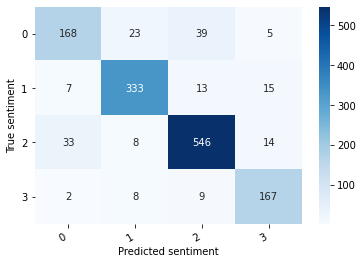

In [42]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

# Real Example



In [43]:
review_text = 'En varias oportunidades me han despachado envíos que no corresponden'

encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt'
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)

print(f"""Prediction value: {
    output.tolist()[0][0], 
    output.tolist()[0][1],
    output.tolist()[0][2],
    output.tolist()[0][3]
    }""")

_, prediction = torch.max(output, dim=1)

clases = ['Other', 'Service', 'App', 'App and Service']

print(f'Review text: {review_text}')
print(f'Category: {clases[prediction]}')

Prediction value: (-2.6946446895599365, 6.016759872436523, -2.2384836673736572, -1.6918046474456787)
Review text: En varias oportunidades me han despachado envíos que no corresponden
Category: Service
